TODO

- gc colect OK
- del variables OK
- new env and requirements.txt OK
- model in pkl
- umap in pkl


# 0.0 Imports

## 0.1 Imports

In [23]:
import pandas as pd
# import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import inflection
import re
import s3fs 
import json
from datetime import datetime

from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import DBSCAN

from umap import UMAP

from sqlalchemy import create_engine

import gc

## 0.2 Helper Functions



In [6]:
# Defining some plot settings
def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    #matplotlib notebook
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    # display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

jupyter_settings()

# def plot_silhouette(X, cluster_labels, ax1 = None):
#     '''
#     Plots a Silhoutte Visualizer image with a silhouette coefficient for each sample on a per-cluster basis.
#     '''    

#     if ax1 is None:
#         ax1 = plt.gca()
    
#     silhouette_avg = silhouette_score(X, cluster_labels)

#     # Compute the silhouette scores for each sample
#     sample_silhouette_values = silhouette_samples(X, cluster_labels)

#     y_lower = 10
#     min_x = 0

#     clusters = np.unique(cluster_labels)
#     n_clusters = len(clusters)        
#     for i in clusters:
#         # Aggregate the silhouette scores for samples belonging to
#         # cluster i, and sort them
#         ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

#         ith_cluster_silhouette_values.sort()

#         min_ith = ith_cluster_silhouette_values.min()
#         if min_ith < min_x:
#             min_x = min_ith

#         size_cluster_i = ith_cluster_silhouette_values.shape[0]
#         y_upper = y_lower + size_cluster_i

#         color = cm.nipy_spectral(float(i) / n_clusters)
        
#         # ploting silhouette
#         ax1.fill_betweenx(
#             np.arange(y_lower, y_upper),
#             0,
#             ith_cluster_silhouette_values,
#             facecolor=color,
#             edgecolor=color,
#             alpha=0.7,
#         )

#         # Label the silhouette plots with their cluster numbers at the middle
#         ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

#         # Compute the new y_lower for next plot
#         y_lower = y_upper + 10  # 10 for the 0 samples

#     ax1.set_title("The silhouette plot for {} clusters.".format(n_clusters))
#     ax1.set_xlabel("The silhouette coefficient values")
#     ax1.set_ylabel("Cluster label")

#     # The vertical line for average silhouette score of all the values
#     ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

#     ax1.set_yticks([])  # Clear the yaxis labels / ticks
#     ax1.set_xticks(np.arange(-1, 1.1, 0.1))
#     ax1.set_xlim([min_x - 0.05, 1])

#     ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

#     print("For n_clusters = {} the average silhouette_score is : {:.4f}".format(n_clusters,silhouette_avg))

#     return(ax1)

# pio.renderers.default = 'notebook_connected'
# # run this to use jupyter notebook or check pio.renderers to select a renderer
# # pio.renderers.default = 'notebook'

# def permutation_test(x, n_a, p, metric = 'mean'):
#     '''
#     Permutates a sample "x" of size "n_a" "p" times and returns a list with difference of means ya - yb
#     '''
#     diffs = []
#     for _ in range(p):
        
#         # shuffle variable
#         np.random.shuffle(x)

#         # calculate difference between metrics:
#         if metric == 'mean':
#             diff = np.mean( x[:n_a] ) - np.mean( x[n_a:] )
#         elif metric == 'median':
#             diff = np.median( x[:n_a] ) - np.median( x[n_a:] )
#         else:
#             raise NameError('Unknown metric. Specifiy "mean" or "median" ')

#         diffs.append(diff)
#     return diffs

## 0.4 Columns Description



### Attribute Description
- InvoiceNo Invoice number (A 6-digit integral number uniquely assigned to each transaction)
- StockCode Product (item) code
- Description Product (item) name
- Quantity The quantities of each product (item) per transaction
- InvoiceDate The day when each transaction was generated
- UnitPrice Unit price (Product price per unit)
- CustomerID Customer number (Unique ID assigned to each customer)
- Country Country name (The name of the country where each customer resides)

# 1.0 Data Description


In [7]:
# df1 = pd.read_csv('../data/raw/ecommerce.csv', encoding='ISO-8859-1', sep = ',')
df1 = pd.read_csv('/home/humberto/DS/insiders_clustering/data/raw/ecommerce.csv', encoding='ISO-8859-1', sep = ',')

# Reading data from S3 Bucket:
# path_s3 = 'https://insiders-raw-data-bucket.s3.sa-east-1.amazonaws.com/raw/'

# df1 = pd.read_csv( path_s3 + 'ecommerce.csv', encoding='ISO-8859-1')

In [8]:
if df1.shape == (541909, 9):
    print('Dimensions ok:{}'.format(df1.shape))
else:
    print('Dimensions differ from expected: {}'.format(df1.shape) )

Dimensions ok:(541909, 9)


## 1.1 Rename Columns

In [9]:
cols_old = df1.columns.tolist()

cols_new = [inflection.underscore(col) for col in cols_old]
cols_new

['invoice_no',
 'stock_code',
 'description',
 'quantity',
 'invoice_date',
 'unit_price',
 'customer_id',
 'country',
 'unnamed: 8']

In [10]:
df1.rename(columns = dict(zip(cols_old, cols_new)), inplace = True )

## 1.2 Data Dimensions

In [11]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of cols: {}'.format( df1.shape[1] ) )

Number of rows: 541909
Number of cols: 9


## 1.3 Data Types

In [12]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
unnamed: 8      float64
dtype: object

## 1.4 NA Check

In [13]:
df1.isna().sum()/df1.shape[0]*100

invoice_no        0.000000
stock_code        0.000000
description       0.268311
quantity          0.000000
invoice_date      0.000000
unit_price        0.000000
customer_id      24.926694
country           0.000000
unnamed: 8      100.000000
dtype: float64

In [14]:
df1.drop(columns=['unnamed: 8'], inplace = True)
df1.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

## 1.5 NA Fillout

In [15]:
df1.dropna(subset=['customer_id'], axis = 0, inplace =  True)
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.6 Changing Data Types


In [16]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


In [17]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [18]:
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format = '%d-%b-%y' )

df1['customer_id'] = df1['customer_id'].astype(int)

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


In [19]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## 1.7 Descriptive Statistics

### 1.7.1 Numerical Attributes

In [21]:
num_att = df1.select_dtypes(include= ['int','float'])
d1 = pd.DataFrame( num_att.min() ).T
d2 = pd.DataFrame( num_att.max() ).T
d3 = pd.DataFrame( num_att.max() - num_att.min() ).T
d4 = pd.DataFrame( num_att.mean() ).T
d5 = pd.DataFrame( num_att.median() ).T
d6 = pd.DataFrame( num_att.std() ).T
d7 = pd.DataFrame( num_att.skew() ).T
d8 = pd.DataFrame( num_att.kurtosis() ).T

desc = pd.concat( [d1, d2, d3, d4, d5, d6, d7, d8] ).T
desc.columns = ['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]
desc.style.format( "{:,.2f}" )

,min,max,range,mean,median,std,skew,kurtosis
quantity,"-80,995.00","80,995.00","161,990.00",12.06,5.00,248.69,0.18,"94,317.56"
unit_price,0.00,"38,970.00","38,970.00",3.46,1.95,69.32,452.22,"246,924.54"
customer_id,"12,346.00","18,287.00","5,941.00","15,287.69","15,152.00","1,713.60",0.03,-1.18


# 2.0 Data Filtering

## 2.1 Data Inspection

In [24]:
df2 = df1.copy()

del df1
gc.collect()

### Stock Code

In [29]:
# selecting rows with only non digits
df_stock = df2.loc[df2['stock_code'].apply( lambda x: bool(re.search('^[\D]+$', x)) )]
df_stock.head(10)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
45,536370,POST,POSTAGE,3,2016-11-29,18.00,12583,France
141,C536379,D,Discount,-1,2016-11-29,27.50,14527,United Kingdom
386,536403,POST,POSTAGE,1,2016-11-29,15.00,12791,Netherlands
1123,536527,POST,POSTAGE,1,2016-11-29,18.00,12662,Germany
2239,536569,M,Manual,1,2016-11-29,1.25,16274,United Kingdom
2250,536569,M,Manual,1,2016-11-29,18.95,16274,United Kingdom
4406,536779,BANK CHARGES,Bank Charges,1,2016-11-30,15.00,15823,United Kingdom
5073,536840,POST,POSTAGE,1,2016-11-30,18.00,12738,Germany
5258,536852,POST,POSTAGE,1,2016-12-01,18.00,12686,France
5325,536858,POST,POSTAGE,2,2016-12-01,40.00,13520,Switzerland


In [30]:
# values to remove
drop_stock = df_stock['stock_code'].unique().tolist()

df_stock['stock_code'].value_counts()

POST            1196
M                465
D                 77
DOT               16
CRUK              16
BANK CHARGES      12
PADS               4
Name: stock_code, dtype: int64

### Country

In [31]:
#countries to drop
drop_country = ['Unspecified', 'European Community']

## 2.2 Data Filtering

In [32]:
# dropping stock code
df2 = df2.loc[~ df2['stock_code'].isin(drop_stock)]

# dropping countries
df2 = df2.loc[~ df2['country'].isin(drop_country)]


# 3.0 Feature Engineering

Now lets calculate recency, frequency and monetary using only purchases (not considering returns as a interaction)

In [34]:
# Reading Data
df3 = df2.copy()

# df3 = pd.read_csv('../data/interim/df2.csv', float_precision='round_trip')
# df3['invoice_date'] = pd.to_datetime( df3['invoice_date'] )

# separating returns from purchases
df_returns = df3.loc[ df3['quantity'] < 0 ]
df_purchases = df3.loc[ df3['quantity'] >= 0 ]

del df2
gc.collect()

667

### Recency

In [35]:
# days since last purchase (considering first day as day after last invoice)
df_recency = df_purchases[['customer_id', 'invoice_date']].copy()
df_recency = df_recency.drop_duplicates(subset = 'customer_id', keep = 'last')

# using final date as max date + 1
df_recency['recency'] =  (pd.to_datetime('2017-12-08') - df_recency['invoice_date']).dt.days
df_recency.drop(columns=['invoice_date'], inplace = True)


### Average Days Between Purchases

In [36]:
df_dates = df_purchases[['customer_id', 'invoice_date']].copy()

# creates a column with the dates shifted by 1 to calculate difference betwenn last purchase and previous purchase
df_dates = df_dates.drop_duplicates()
df_dates['previous_date'] = df_dates.groupby('customer_id')['invoice_date'].shift()

# extracts days betwenn last purchase and previous purchase for each pair of dates
df_dates['days'] = df_dates.apply(lambda x : (x['invoice_date'] - x['previous_date']).days , axis = 1 )

# calculating average of days between purchases
df_dates = df_dates[['customer_id', 'days']].groupby('customer_id').mean().reset_index().rename(columns = {'days': 'avg_days_bw_purchases'})

df_dates.fillna(value = 0, inplace = True)
# df_dates.head()

In [37]:
df_dates = df_purchases[['customer_id', 'invoice_date']].copy()

# creates a column with the dates shifted by 1 to calculate difference betwenn last purchase and previous purchase
df_dates = df_dates.drop_duplicates()
df_dates['previous_date'] = df_dates.groupby('customer_id')['invoice_date'].shift()

# # extracts days betwenn last purchase and previous purchase for each pair of dates
df_dates['days'] = df_dates.apply(lambda x : (x['invoice_date'] - x['previous_date']).days , axis = 1 )

# # calculating average of days between purchases
df_dates = df_dates[['customer_id', 'days']].groupby('customer_id').mean().reset_index().rename(columns = {'days': 'avg_days_bw_purchases'})

df_dates.fillna(value = 0, inplace = True)
# df_dates.isna().sum()
# df_dates[df_dates.customer_id == 12346] #.mean()
# df_dates.head()

### Frequency

In [38]:
# Frequency
# nº of purchases a customer did
df_freq = df_purchases[['invoice_no', 'customer_id']].drop_duplicates('invoice_no').groupby(['customer_id']).count().reset_index().rename(columns = {'invoice_no' : 'num_purchases'} ) #'invoice_date',  #['num_of_purchases']

# difference between firts and last transaction
# if nº purchases made = 1: date range =  today - first purchase date
# else last purchase - first purchase
func = lambda x: (x.max() - x.min() if (x.max() - x.min()).days != 0 else pd.to_datetime('2017-12-08') - x.min() ).days

# aggregating things
df_date_range = df_purchases[[ 'customer_id', 'invoice_date' ]].groupby('customer_id').agg( func ).reset_index().rename(columns = {'invoice_date' : 'date_range'})

df_freq = df_freq.merge(df_date_range, on = 'customer_id', how = 'left')
df_freq['frequency'] = df_freq['num_purchases']/df_freq['date_range']

# df_freq.head()

### Revenue

In [39]:
# revenue
# copying from original dataset so that revenue represents net earnings (purchases - returns)
df_revenue = df3[['unit_price','quantity','customer_id']].copy()
df_revenue['quantity'] = df_revenue['quantity'].astype(float)
df_revenue['customer_spend'] = df_revenue['unit_price']*df_revenue['quantity']

# calculating revenue
df_revenue = df_revenue[['customer_id', 'customer_spend']].groupby('customer_id').sum().reset_index().rename(columns = {'customer_spend' : 'revenue'})

# defining number of purchases
df_revenue = df_revenue.merge( df_freq[['customer_id', 'num_purchases']], on = 'customer_id', how = 'left' )

# calculating avg ticket
df_revenue['avg_ticket'] = df_revenue['revenue']/df_revenue['num_purchases']
df_revenue.drop('num_purchases', axis = 1, inplace = True)

# # deleting rows that we have data about return and not about purchase (purchase outside time frame of dataset)
df_revenue = df_revenue[ df_revenue['revenue'] > 0.1 ].copy()
# df_revenue.head()

### Basket Size

In [40]:
# selecting cols
df_basket = df3[['customer_id', 'invoice_no', 'quantity']].copy()

# counting items per invoice
df_basket = df_basket.groupby(['customer_id', 'invoice_no']).sum().reset_index()

# calculating quantity of items purchased + avg basket size (men of quantities)
df_basket = df_basket.groupby(['customer_id']).agg( qty_items = ('quantity', 'sum'), avg_basket_size = ('quantity', 'mean') ).reset_index()

# renaming
df_basket = df_basket.rename( columns = {'quantity' : 'avg_basket_size'})

# df_basket.head()

### Average Unique Products Purchased Quantity

In [41]:
# selecting cols
df_unique = df_purchases[['customer_id', 'invoice_no', 'stock_code']].copy()

# counting number of different products per invoice
df_unique = df_unique.groupby(['customer_id', 'invoice_no']).nunique().reset_index()

# calculating mean of items per invoice
df_unique = df_unique.groupby(['customer_id']).mean().reset_index()

# # renaming
df_unique = df_unique.rename( columns = {'stock_code' : 'avg_unique_prods'})

# df_unique.head()

### Returns

In [42]:
# creating returns variables

df_returns = df_returns[['quantity', 'invoice_date', 'unit_price', 'customer_id', 'invoice_no']]

df_returns['customer_spend'] = df_returns['unit_price']*df_returns['quantity']

# sum and mean of revenue
df_returns_metrics = df_returns[['customer_id', 'customer_spend', 'quantity']].groupby('customer_id').agg( 
    returns_revenue = ('customer_spend', 'sum'),
    avg_return_revenue = ('customer_spend', 'mean'),
    num_returns = ('customer_spend', 'count'),
    qty_returned = ('quantity', 'sum')  )

df_returns_metrics = pd.DataFrame( df_returns_metrics.to_records() )

# df_returns_metrics.head()

In [43]:
# merging every feature together

df_processed = df_purchases[['customer_id', 'country']].drop_duplicates('customer_id').copy()
df_processed = pd.merge( df_processed, df_recency, on = 'customer_id', how = 'left' )
df_processed = pd.merge( df_processed, df_dates, on = 'customer_id', how = 'left' )
df_processed = pd.merge( df_processed, df_freq, on = 'customer_id', how = 'left' )
df_processed = pd.merge( df_processed, df_revenue, on = 'customer_id', how = 'inner' )
df_processed = pd.merge( df_processed, df_basket, on = 'customer_id', how = 'left' )
df_processed = pd.merge( df_processed, df_unique, on = 'customer_id', how = 'left' )
df_processed = pd.merge( df_processed, df_returns_metrics, on = 'customer_id', how = 'left' )


# filling na as 0 for customers that never returned an item
df_processed.fillna(value = 0, inplace = True)

# df_processed.dropna( inplace = True)
# df_processed.isna().sum()
# df_processed.head(10)
df_processed.shape

(4315, 16)

In [34]:
# df_processed.to_csv('../data/processed/df3_processed.csv', index = False)

# 4.0 Exploratory Data Analysis

In [44]:
# Reading filtered data
# df4 = pd.read_csv('../data/processed/df3_processed.csv')
df4 = df_processed.copy()

del df3, df_processed, df_returns, df_purchases 
gc.collect()

## 4.1 Univariate Analysis

In [54]:
### Returns

df4.sort_values(['returns_revenue'], ascending = True).head()

# This is propably an anomaly, error, or some data purposely inserted for unknown reasons
# df3[df3.customer_id == 16446]
# df3[df3.customer_id == 12346]

# These customers indeed appear to have returned high quantities
# df3[df3.customer_id == 15749]
# df3[df3.customer_id == 16029]
# df3[df3.customer_id == 12931]

# droping weird behaviour
cust_drop = [16446, 12346]
df4 = df4[ ~ df4['customer_id'].isin(cust_drop)].copy()

In [55]:
df4.shape

(4314, 16)

# 5.0 Data Preparation

## 5.1 Numerical Variables Preparation

In [56]:
# df5 = pd.read_csv('../data/processed/df4_processed.csv', float_precision = 'round_trip')
df5 = df4.copy()
df5.shape

(4314, 16)

In [57]:
del df4
gc.collect()

2479

### 5.1.1 Describing

In [58]:
# df3.hist();
num_att = df5.select_dtypes(include= ['int','float'])
d1 = pd.DataFrame( num_att.min() ).T
d2 = pd.DataFrame( num_att.max() ).T
d3 = pd.DataFrame( num_att.max() - num_att.min() ).T
d4 = pd.DataFrame( num_att.mean() ).T
d5 = pd.DataFrame( num_att.median() ).T
d6 = pd.DataFrame( num_att.std() ).T
d7 = pd.DataFrame( num_att.skew() ).T
d8 = pd.DataFrame( num_att.kurtosis() ).T

desc = pd.concat( [d1, d2, d3, d4, d5, d6, d7, d8] ).T
desc.columns = ['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]
desc.style.format( "{:,.2f}" )

,min,max,range,mean,median,std,skew,kurtosis
customer_id,"12,347.00","18,287.00","5,940.00","15,301.83","15,300.50","1,720.16",0.00,-1.20
recency,1.00,374.00,373.00,93.05,51.00,100.17,1.25,0.43
avg_days_bw_purchases,0.00,366.00,366.00,50.57,31.09,65.32,1.99,4.65
num_purchases,1.00,206.00,205.00,4.26,2.00,7.66,11.95,244.12
date_range,1.00,374.00,373.00,187.22,191.00,115.01,0.01,-1.33
frequency,0.00,34.00,34.00,0.05,0.02,0.54,58.77,"3,681.78"
revenue,3.75,"278,778.02","278,774.27","1,922.49",655.34,"8,326.44",21.49,594.95
avg_ticket,3.75,"13,206.50","13,202.75",371.22,283.27,465.09,10.65,202.58
qty_items,1.00,"197,132.00","197,131.00","1,133.25",373.50,"4,701.25",22.96,778.32
avg_basket_size,0.25,"7,824.00","7,823.75",200.17,140.00,269.91,10.01,193.40


# 6.0 Feature Selection

## 6.3 Selected Embedding Space

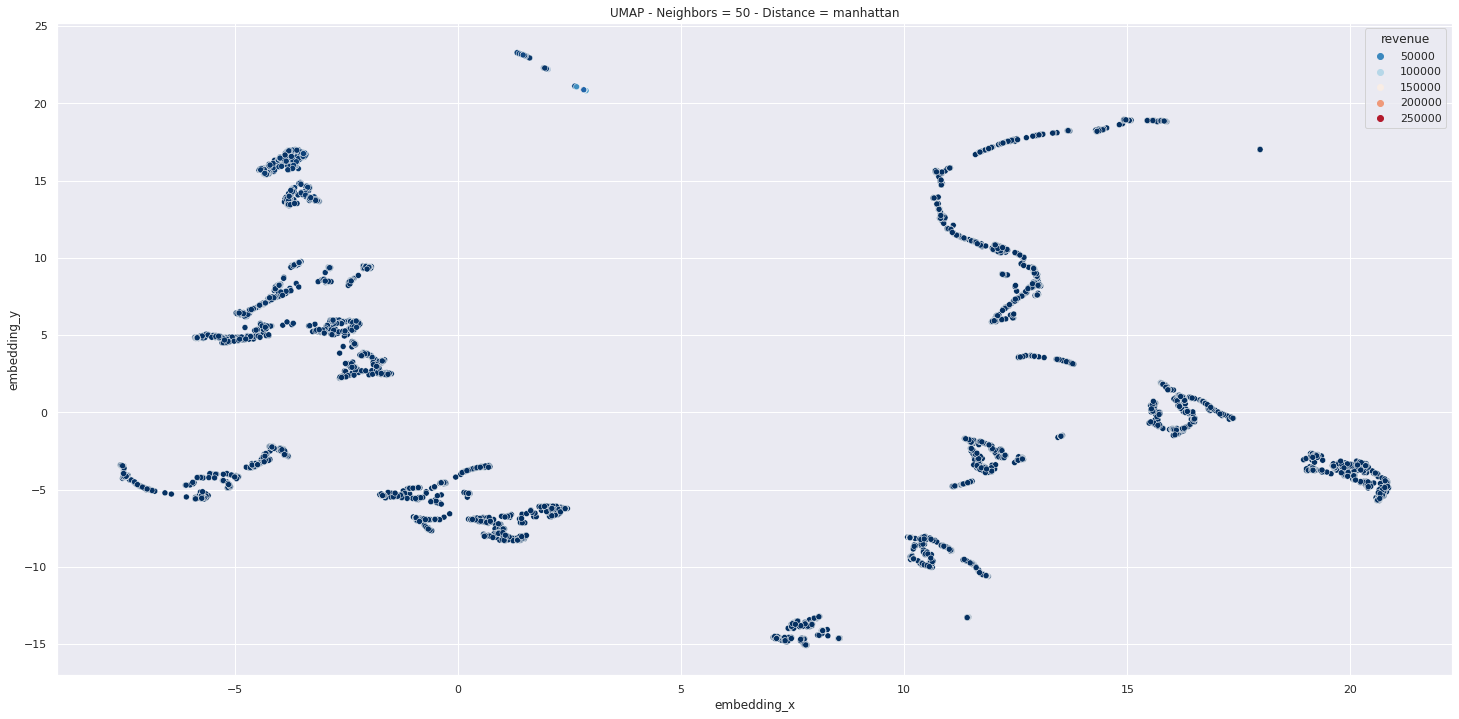

In [59]:
# selecting most important features. Removing ('avg_basket_size', 'avg_days_bw_purchases', 'avg_return_revenue', 'date_range)
cols_selected = ['qty_items','avg_ticket','num_returns','returns_revenue','avg_unique_prods','qty_returned','num_purchases','recency','frequency']

# defining independent and dependent variable
X = df5[cols_selected].copy()
y = df5['revenue']

# defining random forest regresor for embedding
rf = RandomForestRegressor(random_state = 42, min_samples_split = 20) 
rf.fit(X, y)

# get leafs for each observation
df_leaf = pd.DataFrame( rf.apply(X) )

# defining umap algorithm
n_neighbors = 50
umap = UMAP(n_neighbors = n_neighbors, random_state = 42, metric = 'manhattan')  
res_umap = umap.fit_transform(df_leaf)
metric = umap.metric

# storing embedding results on a dataframe
df_tree = df5.copy()
# df_tree = pd.DataFrame()
df_tree['embedding_x'] =  res_umap[:,0]
df_tree['embedding_y'] =  res_umap[:,1]

# ploting results
cmap = sns.color_palette('RdBu_r', as_cmap = True)
plt.title('UMAP - Neighbors = {} - Distance = {}'.format(n_neighbors, metric) )
sns.scatterplot( data = df_tree, x = 'embedding_x', y = 'embedding_y', hue = 'revenue', palette = cmap);

# 7.0 Model Testing

In [69]:
# defining two spaces of data (embedded and rescaled) to test models

# tree embedded data
df_tree = pd.DataFrame()
df_tree['embedding_x'] =  res_umap[:,0]
df_tree['embedding_y'] =  res_umap[:,1]

# rescaled data
df7 = df5.copy()

In [70]:
del X, y, df5
gc.collect()

NameError: name 'X' is not defined

# 8.0 Model Training

In [66]:
df7.shape

(4314, 16)

In [71]:
# defining model 
db_model = DBSCAN(eps = 2.1, min_samples=50)

# applying model 
labels = db_model.fit_predict(df_tree)

df_result = df7.reset_index(drop = True).copy()

# concatenating results
df_result = pd.concat( [df_result, df_tree], axis = 1 )

# defining cluster
df_result['cluster'] = labels.astype(str)

# mapping cluster names
names = {"4" : "Insiders",
         "1" : "Potential Loyalists",
         "0" : "Loyal Customers",
         "2" : "Promissing 1",
         "8" : "Need Attention 1",
         "6" : "Promising 2",
         "7" : "Need Attention 2",
         "5" : "Hibernating 1",
         "10" : "Churn 1",
         "3" : "Price Sensitive",
         "9" : "Churn 2",
         "11" : "Hibernating 2",
         "-1" : 'Noise' }

df_result['cluster_name'] = df_result['cluster'].map(names)

df_result.rename( columns = {'date_range': 'tenure'}, inplace = True)
df_result.head()
df_result.shape

(4314, 20)

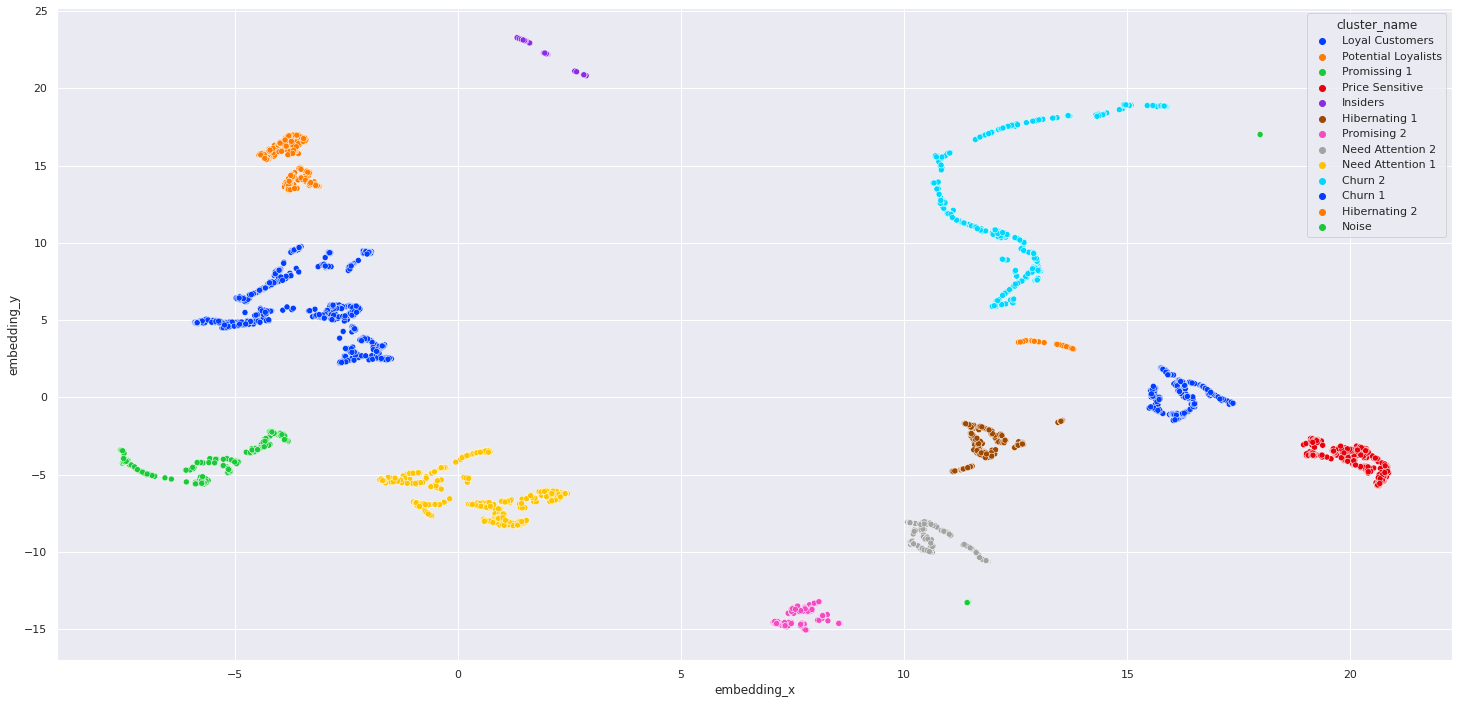

In [72]:
sns.scatterplot(data = df_result, x = 'embedding_x', y = 'embedding_y', hue = 'cluster_name', palette = 'bright');

# 9.0 Cluster Analysis

## 9.4 Business Perspective

### 9.4.1 Clusters Table

In [74]:
# number of customers per cluster
n_cust = df_result.copy()
n_cust = n_cust.groupby('cluster').count().reset_index().rename(columns = {'customer_id' : 'num_of_customers'})
n_cust['perc_of_customer'] = n_cust['num_of_customers']/n_cust['num_of_customers'].sum()*100
n_cust = n_cust[['cluster', 'num_of_customers', 'perc_of_customer']]

In [75]:
# calculating mean values for each cluster attribute
df_res = df_result.copy()

# calculating mothly frequency. Did not like the results of this
# df_res['frequency'] = df_res['frequency']*30

# add cluster to df
result = df_res.groupby('cluster').mean().reset_index()
result

# add nº of customers
result = result.merge( n_cust, on = 'cluster', how = 'inner')
# Based on the RFM Analysis I gave names to clusters 
result['cluster_name'] = result['cluster'].map(names)
result_reduced = result[['cluster_name', 'num_of_customers', 'perc_of_customer', 'recency', 'revenue', 'avg_ticket', 'num_purchases', 'tenure', 'frequency', 'num_returns', 'avg_return_revenue' ]].copy()

#formatting output
result_reduced.sort_values('revenue', ascending = False, inplace = True )
result_reduced['perc_of_customer'] = result_reduced['perc_of_customer'].apply(lambda x: "{:.2f}%".format(x) )
formatter = {"recency" : "{:,.2f}",
"revenue" : "{:,.2f}",
"avg_ticket" : "{:,.2f}",
"num_purchases" : "{:,.2f}",
"tenure" : "{:,.2f}",
"frequency" : "{:,.4f}",
"num_returns" : "{:,.2f}",
"avg_return_revenue" : "{:,.2f}"
}
result_reduced.style.format( formatter = formatter )

,cluster_name,num_of_customers,perc_of_customer,recency,revenue,avg_ticket,num_purchases,tenure,frequency,num_returns,avg_return_revenue
7,Insiders,122,2.83%,19.89,"26,919.61","1,190.97",28.32,315.70,0.1405,16.39,-105.77
2,Potential Loyalists,350,8.11%,29.42,"4,807.84",663.65,10.77,283.83,0.0435,5.75,-15.99
1,Loyal Customers,832,19.29%,44.18,"2,081.88",447.67,5.93,231.45,0.0740,2.51,-10.81
5,Promissing 1,390,9.04%,54.91,"1,229.51",358.42,4.41,199.24,0.0387,1.73,-10.26
11,Need Attention 1,577,13.38%,93.42,777.66,440.05,2.02,135.19,0.0444,0.74,-4.98
9,Promising 2,184,4.27%,67.53,633.76,173.89,3.80,186.69,0.0517,1.99,-9.83
10,Need Attention 2,230,5.33%,90.58,481.55,240.78,2.00,129.31,0.0562,0.52,-2.86
8,Hibernating 1,253,5.86%,136.85,433.87,433.87,1.00,136.85,0.0235,0.32,-2.36
3,Churn 1,294,6.82%,165.18,379.41,348.32,1.10,162.76,0.0195,0.40,-2.77
6,Price Sensitive,306,7.09%,101.30,300.95,123.89,2.53,144.50,0.0670,0.58,-8.80


# 11 Model Deployment

## 11.1. Inserting results on sqlite db

In [47]:
#  connect to db, if doesn't exist create one
# con = sqlite3.connect('../src/features/insiders.db')

In [48]:
# cur = con.cursor()

# cur.execute(
#     """
    # CREATE TABLE insiders (
    #     customer_id               INTEGER,
    #     country                   TEXT,
    #     recency                   INTEGER,
    #     avg_days_bw_purchases     REAL,
    #     num_purchases             INTEGER,
    #     tenure                    INTEGER,
    #     frequency                 REAL,
    #     revenue                   REAL,
    #     avg_ticket                REAL,
    #     qty_items                 INTEGER,
    #     avg_basket_size           REAL,
    #     avg_unique_prods          REAL,
    #     returns_revenue           REAL,
    #     avg_return_revenue        REAL,
    #     num_returns               REAL,
    #     qty_returned              REAL,
    #     embedding_x               REAL,
    #     embedding_y               REAL,
    #     cluster                   TEXT,
    #     cluster_name              TEXT
#     );
#     """
# )

# con.commit()

# # con.close()



In [49]:
# df_result.dtypes

In [50]:
# # con.execute(
# #     """
# #     SELECT name
# #     FROM sqlite_schema
# #     WHERE type ='table'
# #     """
# # )
# cur.execute(
# """SELECT 
#         name
#     FROM 
#         sqlite_master
#     WHERE 
#         type ='table' 
#         ;"""
#         )
# # con.commit()
# #  AND name NOT LIKE 'sqlite_%'
# cur.fetchone()

In [51]:
# con.execute(
#     """
#     DROP TABLE insiders
#     """
# )
# con.commit()

# # con.close()


In [52]:
# conn = create_engine('sqlite:////home/humberto/DS/insiders_clustering/src/features/insiders.db', echo=False)
# df_result.to_sql('insiders', con = conn, if_exists='append', index = False)

In [53]:
# df_sql = pd.read_sql('insiders', con = conn)
# print(df_sql.iloc[0,8])
# print(df_result.iloc[0,8])
# df_sql.head()

## 11.2 Inserting results to mysql db on AWS

In [76]:
# adding last update time to data that will be inserted on DB

now = datetime.now().strftime( "%Y-%m-%d %H:%M:%S" )

df_result['last_update'] = now

In [77]:
df_result.head()

,customer_id,country,recency,avg_days_bw_purchases,num_purchases,tenure,frequency,revenue,avg_ticket,qty_items,avg_basket_size,avg_unique_prods,returns_revenue,avg_return_revenue,num_returns,qty_returned,embedding_x,embedding_y,cluster,cluster_name,last_update
0,17850,United Kingdom,373,1.000000,34,1,34.000000,5288.63,155.547941,1693,48.371429,8.735294,-102.58,-6.838667,15.0,-40.0,-3.543982,9.718514,0,Loyal Customers,2022-03-18 16:57:17
1,13047,United Kingdom,57,52.833333,9,317,0.028391,3089.10,343.233333,1355,84.687500,19.000000,-143.49,-6.238696,23.0,-35.0,-4.025312,8.022521,0,Loyal Customers,2022-03-18 16:57:17
2,12583,France,3,26.500000,15,371,0.040431,6629.34,441.956000,4978,292.823529,15.466667,-76.04,-25.346667,3.0,-50.0,-3.534883,16.845985,1,Potential Loyalists,2022-03-18 16:57:17
3,13748,United Kingdom,96,92.666667,5,278,0.017986,948.25,189.650000,439,87.800000,5.600000,0.00,0.000000,0.0,0.0,-6.975824,-4.942078,2,Promissing 1,2022-03-18 16:57:17
4,15100,United Kingdom,334,20.000000,3,40,0.075000,635.10,211.700000,58,9.666667,1.000000,-240.90,-80.300000,3.0,-22.0,19.139286,-2.679391,3,Price Sensitive,2022-03-18 16:57:17


In [171]:
# # reading credentials

# secrets_json = open('../secrets.json')
# secrets = json.load(secrets_json)

# dialect =   secrets["dialect"]
# driver =    secrets["driver"]
# host =      secrets["host"]
# username =  secrets["username"]
# password =  secrets["password"]
# port =      secrets["port"]
# database =  secrets["database"]

# url = "{}+{}://{}:{}@{}:{}/{}".format(dialect, driver, username, password, host, port, database)

# engine = create_engine(url = url, echo = True) #, pool_pre_ping = True

In [163]:
# read_query = """
#     SELECT * FROM insiders i
# """
# # engine.execute
# df_sql = pd.read_sql_query(read_query, con = engine)

2022-03-18 12:41:55,194 INFO sqlalchemy.engine.Engine 
    SELECT * FROM insiders i

2022-03-18 12:41:55,198 INFO sqlalchemy.engine.Engine [raw sql] {}


In [66]:
# if we had to create table manually we could use this
# create_table = """
#     CREATE TABLE insiders (
#     customer_id               INTEGER,
#     country                   TEXT,
#     recency                   INTEGER,
#     avg_days_bw_purchases     REAL,
#     num_purchases             INTEGER,
#     tenure                    INTEGER,
#     frequency                 REAL,
#     revenue                   REAL,
#     avg_ticket                REAL,
#     qty_items                 INTEGER,
#     avg_basket_size           REAL,
#     avg_unique_prods          REAL,
#     returns_revenue           REAL,
#     avg_return_revenue        REAL,
#     num_returns               REAL,
#     qty_returned              REAL,
#     embedding_x               REAL,
#     embedding_y               REAL,
#     cluster                   TEXT,
#     cluster_name              TEXT
#     )
# """

In [114]:
# inserting data
# df_result.to_sql('insiders', con = engine, if_exists='replace', index = False )

2022-03-18 12:24:02,542 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %(table_schema)s AND table_name = %(table_name)s
2022-03-18 12:24:02,543 INFO sqlalchemy.engine.Engine [cached since 655.7s ago] {'table_schema': 'pa005', 'table_name': 'insiders'}
2022-03-18 12:24:02,675 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %(table_schema)s AND table_name = %(table_name)s
2022-03-18 12:24:02,677 INFO sqlalchemy.engine.Engine [cached since 655.8s ago] {'table_schema': 'pa005', 'table_name': 'insiders'}
2022-03-18 12:24:02,780 INFO sqlalchemy.engine.Engine SHOW FULL TABLES FROM `pa005`
2022-03-18 12:24:02,782 INFO sqlalchemy.engine.Engine [raw sql] {}
2022-03-18 12:24:02,821 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE `insiders`
2022-03-18 12:24:02,822 INFO sqlalchemy.engine.Engine [raw sql] {}
2022-03-18 12:24:02,898 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-03-18 12:24:02,89

4314

In [172]:
# drop_table_query = """
#     DROP TABLE insiders
# """
# engine.execute(drop_table_query)
